### Class 3 - Aggregate Planning
RSM-8423, Winter 2022

### Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Initialize seaborn (for plotting)
sns.set()

### Loading and inspecting data

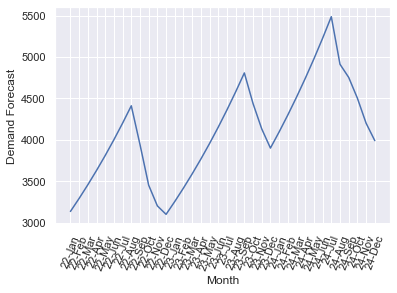

In [2]:
dfForecast = pd.read_csv("projected_demand.csv")

# Let's plot the demand
sns.lineplot(x="Month", y="Demand Forecast", data=dfForecast)
plt.xticks(rotation=70)
plt.show()

In [3]:
dfForecast.head(10)

,Month,Demand Forecast
0,22-Jan,3134
1,22-Feb,3291
2,22-Mar,3456
3,22-Apr,3629
4,22-May,3810
5,22-Jun,4001
6,22-Jul,4201
7,22-Aug,4411
8,22-Sep,3943
9,22-Oct,3451


## Basic flow model

### Sets and parameters

In [5]:
# Periods to consider 
numperiods = dfForecast.shape[0]

# Set of periods
periods = range(0, numperiods)

# Set of demands
demand = dfForecast["Demand Forecast"]

### Variables

In [6]:
import pulp

# Initialize model and objective sense
flowModel = pulp.LpProblem(name="FlowModel", sense=pulp.LpMinimize)

# Production variables
pvar = pulp.LpVariable.dict("p", periods, lowBound=0.0, upBound=4500.0, cat=pulp.LpContinuous)

# Left-over inventory variables
ivar = pulp.LpVariable.dict("i", periods, lowBound=0.0, cat=pulp.LpContinuous)

### Constraints

In [7]:
# Balance of flow constraints
for t in periods:
    leftoverperiod = (ivar[t-1] if t > 0 else 0) + pvar[t] - demand[t]
    flowModel += (ivar[t] == leftoverperiod)

### Objective

In [8]:
# Objective function
obj = pulp.lpSum([ 50 * pvar[t] + 10 * ivar[t] for t in periods ])
flowModel += obj

### Solution

In [9]:
# Write LP to file (optional, but often good to find errors)
flowModel.writeLP("flowModel.lp")

# Solve model
flowModel.solve()
print("Status:", pulp.LpStatus[flowModel.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/cireandr/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/p6/k9kpfkxx7h78ybc6p8j_mp2m0000gp/T/52c078bffde74e1caf2ae3fda0faf8db-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/p6/k9kpfkxx7h78ybc6p8j_mp2m0000gp/T/52c078bffde74e1caf2ae3fda0faf8db-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 41 COLUMNS
At line 221 RHS
At line 258 BOUNDS
At line 295 ENDATA
Problem MODEL has 36 rows, 72 columns and 107 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (-19) rows, 52 (-20) columns and 68 (-39) elements
0  Obj -2800899.2 Primal inf 137234.3 (17)
29  Obj 7705830
Optimal - objective value 7705830
After Postsolve, objective 7705830, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 7705830 - 29 iterations time 0.002, Presolve 0.00

In [10]:
# Total cost
totalCost = pulp.value(flowModel.objective)
print("Total cost: " + str(totalCost))

Total cost: 7705830.0


In [11]:
# Add optimal solution to table
dfForecast["Suggested Production"] = [ pvar[t].varValue for t in periods ]
dfForecast["Suggested Inventory"]  = [ ivar[t].varValue for t in periods ]
dfForecast

,Month,Demand Forecast,Suggested Production,Suggested Inventory
0,22-Jan,3134,3134.0,0.0
1,22-Feb,3291,3291.0,0.0
2,22-Mar,3456,3456.0,0.0
3,22-Apr,3629,3629.0,0.0
4,22-May,3810,3810.0,0.0
5,22-Jun,4001,4001.0,0.0
6,22-Jul,4201,4201.0,0.0
7,22-Aug,4411,4411.0,0.0
8,22-Sep,3943,3943.0,0.0
9,22-Oct,3451,3451.0,0.0


### A more complex network...

(I wrote in a single cell, but when writing try to separate sets/parameters, variables, and objective function)

In [12]:
# Main differences are marked with "****"

# Initialize model and objective sense
workerModel = pulp.LpProblem(name="WorkerModel", sense=pulp.LpMinimize)

# Periods to consider 
numperiods = dfForecast.shape[0]

periods = range(0, numperiods)

# Production variables
pvar = pulp.LpVariable.dict("p", periods, lowBound=0.0, upBound=4500.0, cat=pulp.LpContinuous)

# Left-over inventory variables
ivar = pulp.LpVariable.dict("i", periods, lowBound=0.0, cat=pulp.LpContinuous)

# **** Worker flow ****
wvar = pulp.LpVariable.dict("w", periods, lowBound=0.0, cat=pulp.LpContinuous)

# **** New hires ****
hvar = pulp.LpVariable.dict("h", periods, lowBound=0.0, cat=pulp.LpInteger)

# Balance of flow constraints
demand = dfForecast["Demand Forecast"]

for t in periods:
    # Inventory flow
    leftoverperiod = (ivar[t-1] if t > 0 else 0) + pvar[t] - demand[t]
    workerModel += (ivar[t] == leftoverperiod)
    
    # Worker flow
    numworkers = (wvar[t-1] if t > 0 else 0) + hvar[t]
    workerModel += (wvar[t] == numworkers)
    
    # Capacity is limited by the number of workers
    workerModel += (pvar[t] <= 100 * wvar[t])

# *** Objective function ***
obj = pulp.lpSum([ 50 * pvar[t] + 10 * ivar[t] + 200 * wvar[t] for t in periods ])
workerModel += obj

# Write LP to file (optional, but often good to find errors)
workerModel.writeLP("workerModel.lp")

# Solve model
workerModel.solve()
print("Status:", pulp.LpStatus[workerModel.status])


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/cireandr/opt/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/p6/k9kpfkxx7h78ybc6p8j_mp2m0000gp/T/f017b067fd8b42de9ce1b813734e610a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/p6/k9kpfkxx7h78ybc6p8j_mp2m0000gp/T/f017b067fd8b42de9ce1b813734e610a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 113 COLUMNS
At line 580 RHS
At line 689 BOUNDS
At line 762 ENDATA
Problem MODEL has 108 rows, 144 columns and 286 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8.01603e+06 - 0.00 seconds
Cgl0003I 0 fixed, 70 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 69 rows, 105 columns (36 integer (0 of which binary)) and 225 elements
Cbc0012I Integer solution of 8016820 found by DiveCoefficient afte

In [13]:
# Total cost
totalCost = pulp.value(workerModel.objective)
print("Total cost: " + str(totalCost))

Total cost: 8016760.0


In [14]:
# Add optimal solution to table
dfForecast["Suggested Production"] = [ pvar[t].varValue for t in periods ]
dfForecast["Suggested Inventory"]  = [ ivar[t].varValue for t in periods ]
dfForecast["Suggested Hiring"]  = [ hvar[t].varValue for t in periods ]
dfForecast["Suggested Panel"]  = [ wvar[t].varValue for t in periods ]
dfForecast

,Month,Demand Forecast,Suggested Production,Suggested Inventory,Suggested Hiring,Suggested Panel
0,22-Jan,3134,3134.0,0.0,32.0,32.0
1,22-Feb,3291,3291.0,0.0,1.0,33.0
2,22-Mar,3456,3456.0,0.0,2.0,35.0
3,22-Apr,3629,3639.0,10.0,2.0,37.0
4,22-May,3810,3800.0,0.0,1.0,38.0
5,22-Jun,4001,4013.0,12.0,3.0,41.0
6,22-Jul,4201,4300.0,111.0,2.0,43.0
7,22-Aug,4411,4300.0,0.0,0.0,43.0
8,22-Sep,3943,3943.0,0.0,0.0,43.0
9,22-Oct,3451,3451.0,0.0,0.0,43.0
